### Imports

In [83]:
!pip install Unidecode
!pip install nltk
nltk.download("popular")
nltk.download('rslp')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

True

In [84]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc)

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import copy as copy
import unidecode

import nltk
from nltk import tokenize
from string import punctuation
import numpy as np

### 1. Carregar os dados

In [85]:
df = pd.read_csv('text.csv')

df = df[(df['label'] == 0) | (df['label'] == 1)].copy().reset_index(drop=True)
df = df.drop(columns=df.columns[0], axis=1)

df.head()

,text,label
0,ive enjoyed being able to slouch about relax a...,0.0
1,i dont know i feel so lost,0.0
2,i was beginning to feel quite disheartened,0.0
3,i fear that they won t ever feel that deliciou...,1.0
4,i can still lose the weight without feeling de...,0.0


### Pré-Processamento

In [86]:
def df_lower(df_column):
    return df_column.apply(lambda x : x.lower())

def remove_accents(df_column):
    return [unidecode.unidecode(text) for text in df_column]

def remove_stopword(df, column_name):
    stopwords = nltk.corpus.stopwords.words("english")
    tokenizer = tokenize.WordPunctTokenizer()
    
    for ponto in punctuation:
        stopwords.append(ponto)
    
    frase_processada = list()
    for review in df[column_name]:
      nova_frase = list()
      palavras_texto = tokenizer.tokenize(review)
      for palavra in palavras_texto:
          if palavra not in stopwords:
              nova_frase.append(palavra)
      frase_processada.append(' '.join(nova_frase))

    return frase_processada

df.text = df_lower(df.text)
df.text = remove_accents(df.text)
df.text = remove_stopword(df, 'text')
df.head()

,text,label
0,ive enjoyed able slouch relax unwind frankly n...,0.0
1,dont know feel lost,0.0
2,beginning feel quite disheartened,0.0
3,fear ever feel delicious excitement christmas ...,1.0
4,still lose weight without feeling deprived,0.0


### 2. Separar entre treino e teste

In [87]:
x = df['text']
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, test_size=0.2, stratify=y)

### 3. Criar validação cruzada com o conjunto de treino + Criar as features com TD-IDF

In [88]:
n_splits = 5
kfolds = KFold(n_splits = n_splits)
n_neighbors = list(range(5, 51, 5))

In [89]:
# Functions

def define_kfold_subsets(x_train, y_train, train_idx, val_idx):
    # Train subset
    x_train_kfold = x_train.iloc[train_idx]
    x_val_kfold = x_train.iloc[val_idx]
    
    # Validation subset
    y_train_kfold = y_train.iloc[train_idx]
    y_val_kfold = y_train.iloc[val_idx]

    return x_train_kfold, x_val_kfold, y_train_kfold, y_val_kfold
    

def vectorizer(x_train_kfold, x_val_kfold):
    tfidf = TfidfVectorizer(min_df = 10, max_features = 5000)
    bow_train = tfidf.fit_transform(x_train_kfold)
    bow_val = tfidf.transform(x_val_kfold)

    return tfidf, bow_train, bow_val
    

def score(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "cm": confusion_matrix(y_true, y_pred),
    }

In [90]:
results = []

for nn in tqdm(n_neighbors):

    results_fold = []
    
    for fold, (train_idx, val_idx) in tqdm(enumerate(kfolds.split(y_train)), total = n_splits):
        # CREATE KNN
        model = KNeighborsClassifier(n_neighbors = nn)
        
        # Define subsets
        x_train_kfold, x_val_kfold, y_train_kfold, y_val_kfold = define_kfold_subsets(x_train, y_train, train_idx, val_idx)
        
        # Vectorizer subsets
        tfidf, bow_train, bow_val = vectorizer(x_train_kfold, x_val_kfold)
        
        # Train
        model.fit(bow_train, y_train_kfold)

        # Assess Performance
        y_train_kfold_pred = model.predict(bow_train)
        y_val_kfold_pred = model.predict(bow_val)

        results_fold.append({
            "tfidf": copy.deepcopy(tfidf),
            "fold": fold,
            "train": score(y_train_kfold, y_train_kfold_pred),
            "val": score(y_val_kfold, y_val_kfold_pred),
            "model": copy.deepcopy(model),
        })
    results.append({
        "n_neighbors": nn,
        "results": results_fold
    })

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### 4. Avaliar resultados de treino

In [91]:
'''
for item in results:
    fold_result = [i["val"] for i in item["results"]] # 5 dicionarios de acc, recall, etc
    
    keys = list(fold_result[0].keys())
    keys = [k for k in keys if k != "cm"]
    
    fold_result_df = pd.DataFrame(fold_result)
    fold_result_df_mean = fold_result_df[keys].mean()
    fold_result_df_std = fold_result_df[keys].std()

    print("VAL Model: k = ", item['n_neighbors'])
    for k in keys:
        print(k, "%.2f"%fold_result_df_mean[k], "± %0.2f"%fold_result_df_std[k])
    print()

    fold_result = [i["train"] for i in item["results"]]
    
    keys = list(fold_result[0].keys())
    keys = [k for k in keys if k != "cm"]
    
    fold_result_df = pd.DataFrame(fold_result)
    fold_result_df_mean = fold_result_df[keys].mean()
    fold_result_df_std = fold_result_df[keys].std()

    print(fold_result_df_mean['accuracy'])

    print("TRAIN Model: k = ", item['n_neighbors'])
    for k in keys:
        print(k, "%.2f"%fold_result_df_mean[k], "± %0.2f"%fold_result_df_std[k])
    print("")
    print("---")
'''

'\nfor item in results:\n    fold_result = [i["val"] for i in item["results"]] # 5 dicionarios de acc, recall, etc\n    \n    keys = list(fold_result[0].keys())\n    keys = [k for k in keys if k != "cm"]\n    \n    fold_result_df = pd.DataFrame(fold_result)\n    fold_result_df_mean = fold_result_df[keys].mean()\n    fold_result_df_std = fold_result_df[keys].std()\n\n    print("VAL Model: k = ", item[\'n_neighbors\'])\n    for k in keys:\n        print(k, "%.2f"%fold_result_df_mean[k], "± %0.2f"%fold_result_df_std[k])\n    print()\n\n    fold_result = [i["train"] for i in item["results"]]\n    \n    keys = list(fold_result[0].keys())\n    keys = [k for k in keys if k != "cm"]\n    \n    fold_result_df = pd.DataFrame(fold_result)\n    fold_result_df_mean = fold_result_df[keys].mean()\n    fold_result_df_std = fold_result_df[keys].std()\n\n    print(fold_result_df_mean[\'accuracy\'])\n\n    print("TRAIN Model: k = ", item[\'n_neighbors\'])\n    for k in keys:\n        print(k, "%.2f"%fold

In [92]:
row_list = []
for item in results:
    fold_result = [i["val"] for i in item["results"]]
    
    keys = list(fold_result[0].keys())
    keys = [k for k in keys if k != "cm"]
    
    fold_result_df = pd.DataFrame(fold_result)
    fold_result_df_mean = fold_result_df[keys].mean()
    fold_result_df_std = fold_result_df[keys].std()

    list_values = [item['n_neighbors']]
    for k in keys:
        list_values.append("{:.2f} ± {:0.2f}".format(fold_result_df_mean[k], fold_result_df_std[k]))
    
    row_list.append(list_values)

df_results = pd.DataFrame(row_list, columns = ['k'] + keys)
df_results

,k,accuracy,recall,precision,f1
0,5,0.74 ± 0.11,0.54 ± 0.24,0.94 ± 0.03,0.66 ± 0.18
1,10,0.89 ± 0.02,0.83 ± 0.04,0.97 ± 0.01,0.89 ± 0.02
2,15,0.93 ± 0.00,0.92 ± 0.02,0.95 ± 0.01,0.94 ± 0.01
3,20,0.93 ± 0.01,0.91 ± 0.02,0.96 ± 0.01,0.94 ± 0.01
4,25,0.95 ± 0.00,0.94 ± 0.01,0.96 ± 0.00,0.95 ± 0.00
5,30,0.95 ± 0.00,0.94 ± 0.01,0.96 ± 0.01,0.95 ± 0.00
6,35,0.95 ± 0.00,0.95 ± 0.01,0.96 ± 0.00,0.95 ± 0.00
7,40,0.95 ± 0.00,0.95 ± 0.01,0.96 ± 0.00,0.95 ± 0.00
8,45,0.95 ± 0.00,0.96 ± 0.01,0.96 ± 0.00,0.96 ± 0.00
9,50,0.95 ± 0.00,0.95 ± 0.01,0.96 ± 0.00,0.96 ± 0.00


### 5. Avaliar resultados de teste

In [93]:
results_test = []

for n_knn in tqdm(results):
    results_fold = []
    for kfold in tqdm(n_knn['results']):
        bow_test = kfold['tfidf'].transform(x_test)
        y_test_pred = kfold['model'].predict(bow_test)
        results_fold.append({
            "fold": kfold['fold'],
            "test": score(y_test, y_test_pred),
        })
    results_test.append({
        "n_neighbors": n_knn['n_neighbors'],
        "results": results_fold
    })

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [94]:
'''
for item in results_test:
    fold_result = [i["test"] for i in item["results"]]
    
    keys = list(fold_result[0].keys())
    keys = [k for k in keys if k != "cm"]
    
    fold_result_df = pd.DataFrame(fold_result)
    fold_result_df_mean = fold_result_df[keys].mean()
    fold_result_df_std = fold_result_df[keys].std()

    print("VAL Model: k = ", item['n_neighbors'])
    for k in keys:
        print(k, "%.2f"%fold_result_df_mean[k], "± %0.2f"%fold_result_df_std[k])
    print()
'''

'\nfor item in results_test:\n    fold_result = [i["test"] for i in item["results"]]\n    \n    keys = list(fold_result[0].keys())\n    keys = [k for k in keys if k != "cm"]\n    \n    fold_result_df = pd.DataFrame(fold_result)\n    fold_result_df_mean = fold_result_df[keys].mean()\n    fold_result_df_std = fold_result_df[keys].std()\n\n    print("VAL Model: k = ", item[\'n_neighbors\'])\n    for k in keys:\n        print(k, "%.2f"%fold_result_df_mean[k], "± %0.2f"%fold_result_df_std[k])\n    print()\n'

In [95]:
row_list = []
for item in results_test:
    fold_result = [i["test"] for i in item["results"]]
    
    keys = list(fold_result[0].keys())
    keys = [k for k in keys if k != "cm"]
    
    fold_result_df = pd.DataFrame(fold_result)
    fold_result_df_mean = fold_result_df[keys].mean()
    fold_result_df_std = fold_result_df[keys].std()

    list_values = [item['n_neighbors']]
    for k in keys:
        list_values.append("{:.2f} ± {:0.2f}".format(fold_result_df_mean[k], fold_result_df_std[k]))
    
    row_list.append(list_values)

df_results_test = pd.DataFrame(row_list, columns = ['k'] + keys)
df_results_test

,k,accuracy,recall,precision,f1
0,5,0.73 ± 0.11,0.54 ± 0.24,0.94 ± 0.04,0.66 ± 0.18
1,10,0.89 ± 0.02,0.83 ± 0.04,0.97 ± 0.01,0.89 ± 0.02
2,15,0.94 ± 0.01,0.92 ± 0.02,0.95 ± 0.01,0.94 ± 0.01
3,20,0.94 ± 0.00,0.92 ± 0.01,0.96 ± 0.01,0.94 ± 0.00
4,25,0.95 ± 0.00,0.94 ± 0.01,0.96 ± 0.01,0.95 ± 0.00
5,30,0.95 ± 0.00,0.94 ± 0.01,0.96 ± 0.01,0.95 ± 0.00
6,35,0.95 ± 0.00,0.95 ± 0.01,0.96 ± 0.00,0.95 ± 0.00
7,40,0.95 ± 0.00,0.95 ± 0.00,0.96 ± 0.00,0.96 ± 0.00
8,45,0.95 ± 0.00,0.96 ± 0.00,0.96 ± 0.01,0.96 ± 0.00
9,50,0.96 ± 0.00,0.95 ± 0.00,0.96 ± 0.00,0.96 ± 0.00


### ROC CURVE

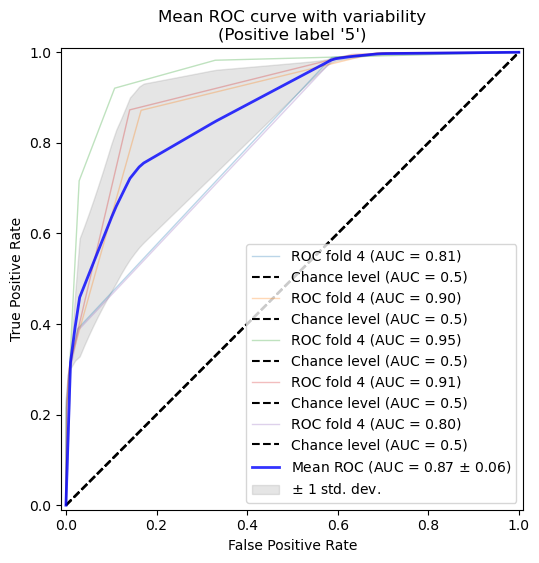

In [99]:
n_knn = results[0]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for kfold in n_knn['results']:
    classifier = kfold['model']
    bow_test_roc = kfold['tfidf'].transform(x_test)
    viz = RocCurveDisplay.from_estimator(
        classifier,
        bow_test_roc,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Number of Neighbors: {n_knn['n_neighbors']})",
)
ax.legend(loc="lower right")
plt.show()

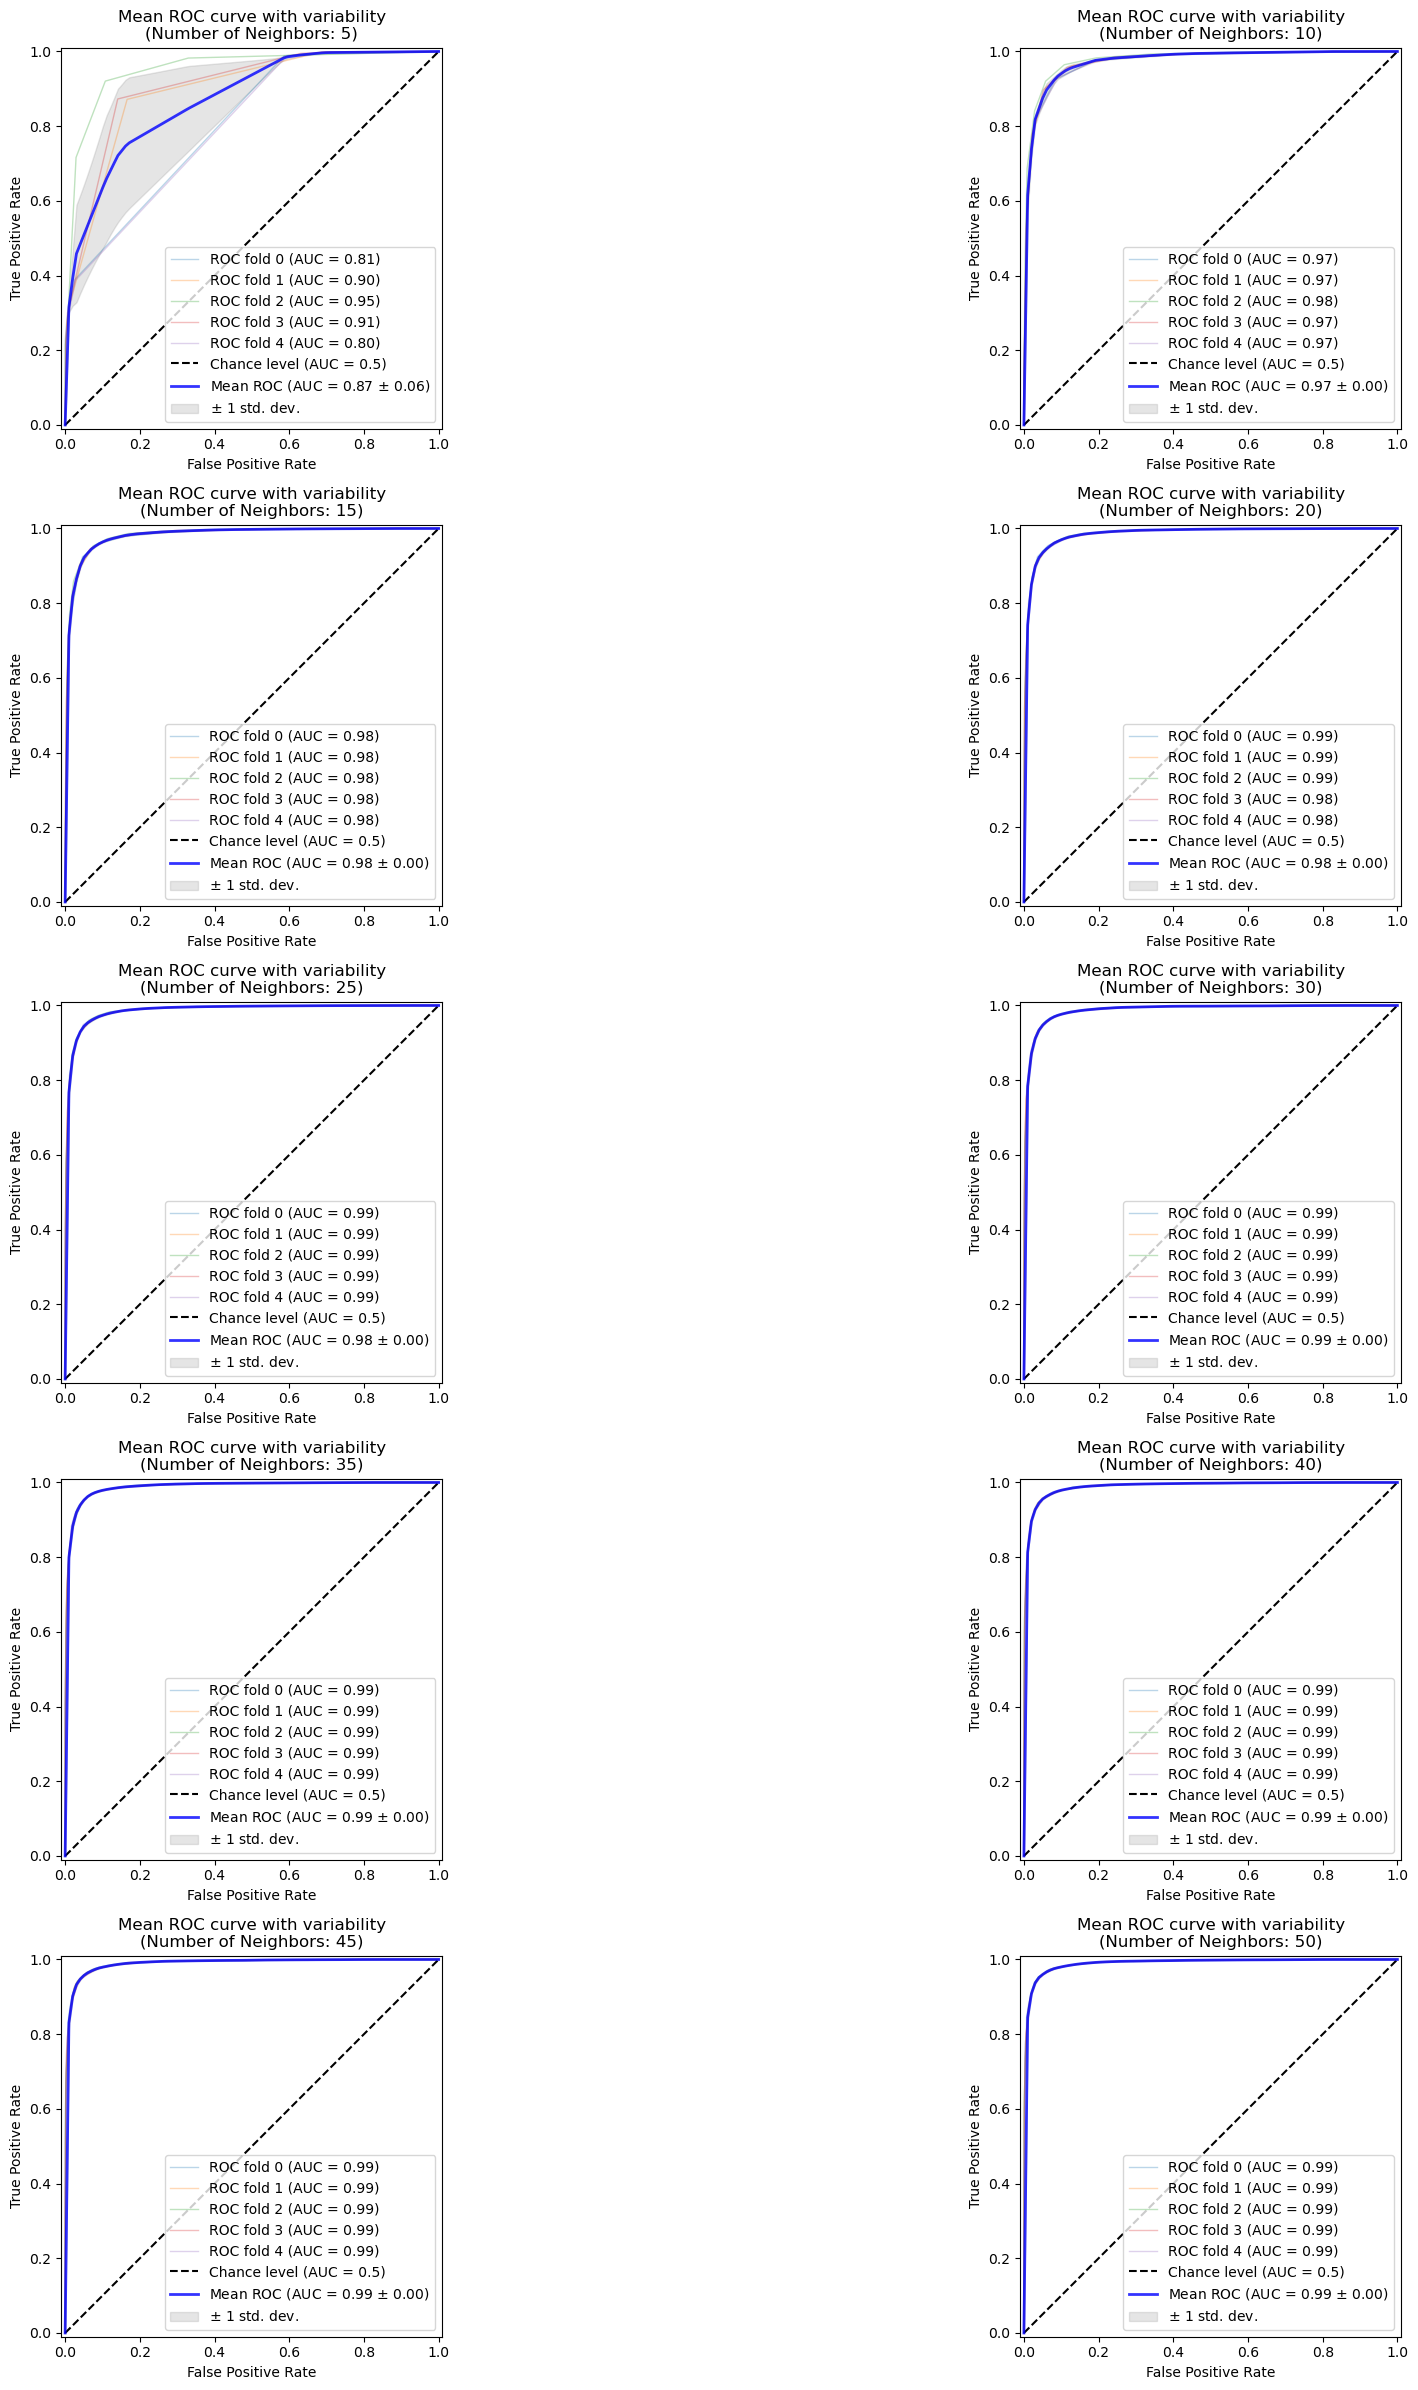

In [106]:
n_rows = 5  # Number of rows in the grid
n_cols = 2  # Number of columns in the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))
axes = axes.flatten()  # Flatten the axes array to easily iterate over it

for i, n_knn in enumerate(results):
#for i in tqdm(range(0,2)):
    n_knn = results[i]
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    ax = axes[i]
    
    for fold, kfold in enumerate(n_knn['results']):
        classifier = kfold['model']
        bow_test_roc = kfold['tfidf'].transform(x_test)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            bow_test_roc,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == len(n_knn['results']) - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Number of Neighbors: {n_knn['n_neighbors']})",
    )
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()